In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
from sklearn import preprocessing
import dlib
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import timeit
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
from TorchCRF import CRF

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def read_OCR(filename, n_features):
    with open(filename) as F:
        dataset = {
            'ids': [],
            'labels': [],
            'labelDic': {},
            'next_ids': [],
            'word_ids': [],
            'positions': [],
            'folds': [],
            'features': []
        }
        for str_line in F.readlines():
            line0 = list(map(lambda x: int(x) if x.isdigit() else x, filter(None, re.split('\t', str_line.strip()))))
            dataset['ids'].append(int(line0.pop(0)))
            dataset['labels'].append(int(ord(line0.pop(0)) - ord('a')))
            if dataset['labels'][-1] in dataset['labelDic']:
                dataset['labelDic'][dataset['labels'][-1]] += 1
            else:
                dataset['labelDic'][dataset['labels'][-1]] = 1
            dataset['next_ids'].append(int(line0.pop(0)))
            dataset['word_ids'].append(int(line0.pop(0)))
            dataset['positions'].append(int(line0.pop(0)))
            dataset['folds'].append(int(line0.pop(0)))
            dataset['features'].append(line0)

    return dataset


In [4]:
dataset1 = read_OCR('OCRdataset/letter.data', 128)
print(f"Dataset loaded with {len(dataset1['features'])} samples.")

Dataset loaded with 52152 samples.


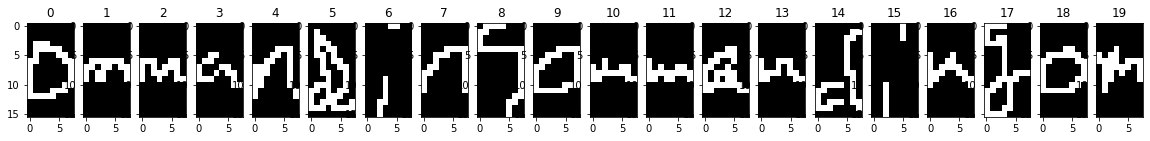

In [5]:
def showFeatures(features, num):
    plt.figure(figsize=(num, 6))
    for i in range(num):
        npfeature = np.array(features[i])
        plt.subplot(1, num, i + 1)
        imshow(npfeature.reshape(16, 8), cmap='gray')
        plt.title(i)

showFeatures(dataset1['features'], 20)

In [6]:
L = 2
N = 5000
d = 128

def structurize1(dataset, N, L):
    d_features = len(dataset['features'][0])
    y = dataset['labels']
    X = dataset['features']
    next_id = dataset['next_ids']

    labels = np.zeros((N, L))
    features = np.zeros((N, L, d_features))

    def extract(iN, loc):
        labels[iN] = y[loc:loc + L]
        features[iN] = np.array(X[loc:loc + L])
        iN += 1
        return iN

    iN = 0
    iN = extract(iN, 0)
    for key, value in enumerate(y):
        if next_id[key] == -1:
            iN = extract(iN, key + 1)
            if iN == N:
                break

    c = list(zip(labels, features))
    random.shuffle(c)
    labels, features = zip(*c)
    return np.array(labels), np.array(features)


In [7]:
labels1, features1 = structurize1(dataset1, N, L)
print(f"Features and labels structured: {features1.shape}, {labels1.shape}")

le1 = preprocessing.LabelEncoder()
nplabels1 = le1.fit_transform(labels1.ravel()).reshape(labels1.shape)
print(f"Labels encoded: {np.unique(nplabels1)}")

#shape for lstm layer?
npsamples1 = features1  
print(f"Reshaped samples: {npsamples1.shape}")
K1 = len(le1.classes_)
print(f"Number of classes: {K1}")

Features and labels structured: (5000, 2, 128), (5000, 2)
Labels encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Reshaped samples: (5000, 2, 128)
Number of classes: 23


In [12]:
def sliding_window(data, labels, window_size):
    windows = []
    window_labels = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_label = labels[i:i + window_size]
        windows.append(window)
        window_labels.append(window_label)
    windows = np.array(windows)
    window_labels = np.array(window_labels)
    print(f"Sliding window generated {len(windows)} windows with shape {windows.shape}")
    return windows, window_labels


In [13]:
class CRFModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CRFModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, output_dim)
        self.crf = CRF(output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        emissions = self.hidden2tag(lstm_out)
        return emissions

In [14]:
class CRFModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CRFModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, output_dim)
        self.crf = CRF(output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        emissions = self.hidden2tag(lstm_out)
        return emissions

def train_and_evaluate_crf(N_train, N_test, window_size, n_epochs=10):
    print(f'Starting training with {N_train} samples and testing with {N_test} samples.')

    tr_windows, tr_labels = sliding_window(npsamples1[:N_train], nplabels1[:N_train], window_size)
    te_windows, te_labels = sliding_window(npsamples1[N_train:N_train + N_test], nplabels1[N_train:N_train + N_test], window_size)

    tr_labels = torch.tensor(tr_labels, dtype=torch.long, device=device).view(-1, window_size)
    tr_windows = torch.tensor(tr_windows, dtype=torch.float, device=device).view(-1, window_size, d)
    te_labels = torch.tensor(te_labels, dtype=torch.long, device=device).view(-1, window_size)
    te_windows = torch.tensor(te_windows, dtype=torch.float, device=device).view(-1, window_size, d)

    tr_mask = torch.ones(tr_labels.shape, dtype=torch.uint8, device=device)
    te_mask = torch.ones(te_labels.shape, dtype=torch.uint8, device=device)

    model = CRFModel(tr_windows.shape[2], 128, K1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    start_train = timeit.default_timer()
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        emissions = model(tr_windows)
        loss = -model.crf(emissions, tr_labels, mask=tr_mask).mean()
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}/{n_epochs} completed with loss: {loss.item()}')
    end_train = timeit.default_timer()
    training_time = end_train - start_train

    training_accuracy = cal_accuracy_crf(tr_windows, tr_labels, tr_mask, model)
    testing_accuracy = cal_accuracy_crf(te_windows, te_labels, te_mask, model)
    print(f'Training completed in {training_time} seconds.')
    print(f'Training accuracy: {training_accuracy}')
    print(f'Testing accuracy: {testing_accuracy}')

    return model, training_time, training_accuracy, testing_accuracy

def cal_accuracy_crf(samples, labels, mask, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        emissions = model(samples)
        for i in range(len(samples)):
            pred = viterbi_decode(emissions[i], mask[i])
            true = labels[i].tolist()
            correct += sum(p == t for p, t in zip(pred, true))
            total += len(true)
    accuracy = correct / total
    print(f"Accuracy calculated: {accuracy}")
    return accuracy

def viterbi_decode(emissions, mask):
    seq_length, num_tags = emissions.shape
    scores = emissions[0]
    paths = torch.zeros((seq_length, num_tags), dtype=torch.long)

    for t in range(1, seq_length):
        scores_t = scores.unsqueeze(1) + emissions[t].unsqueeze(0)
        scores_t, indices = scores_t.max(dim=0)
        scores = scores_t
        paths[t] = indices

    best_score, best_path = scores.max(dim=0)
    best_path = [best_path.item()]

    for t in range(seq_length - 1, 0, -1):
        best_path.insert(0, paths[t, best_path[0]].item())

    return best_path


m

In [17]:
def generate_context_features(samples, model, window_size):
    model.eval()
    context_features = []
    with torch.no_grad():
        emissions = model(samples)
        for i in range(len(samples)):
            pred = viterbi_decode(emissions[i], mask=torch.ones(emissions[i].shape[0], dtype=torch.uint8, device=device))
            context_features.append(pred)
    context_features = np.array(context_features)
    context_features = context_features.reshape(samples.shape[0], samples.shape[1], -1)
    return context_features

def train_autocontext_crf(N_train, N_test, window_size, n_epochs=10):
    initial_model, _, _, _ = train_and_evaluate_crf(N_train, N_test, window_size, n_epochs)

    tr_windows, tr_labels = sliding_window(npsamples1[:N_train], nplabels1[:N_train], window_size)
    te_windows, te_labels = sliding_window(npsamples1[N_train:N_train + N_test], nplabels1[N_train:N_train + N_test], window_size)

    tr_labels = torch.tensor(tr_labels, dtype=torch.long, device=device).view(-1, window_size)
    tr_windows = torch.tensor(tr_windows, dtype=torch.float, device=device).view(-1, window_size, d)
    te_labels = torch.tensor(te_labels, dtype=torch.long, device=device).view(-1, window_size)
    te_windows = torch.tensor(te_windows, dtype=torch.float, device=device).view(-1, window_size, d)

    tr_mask = torch.ones(tr_labels.shape, dtype=torch.uint8, device=device)
    te_mask = torch.ones(te_labels.shape, dtype=torch.uint8, device=device)

    tr_context = generate_context_features(tr_windows, initial_model, window_size)
    te_context = generate_context_features(te_windows, initial_model, window_size)

    tr_context = torch.tensor(tr_context, dtype=torch.float, device=device)
    te_context = torch.tensor(te_context, dtype=torch.float, device=device)

    tr_combined = torch.cat((tr_windows, tr_context), dim=2)
    te_combined = torch.cat((te_windows, te_context), dim=2)

    model = CRFModel(tr_combined.shape[2], 128, K1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    start_train = timeit.default_timer()
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        emissions = model(tr_combined)
        loss = -model.crf(emissions, tr_labels, mask=tr_mask).mean()
        loss.backward()
        optimizer.step()
    end_train = timeit.default_timer()
    training_time = end_train - start_train

    training_accuracy = cal_accuracy_crf(tr_combined, tr_labels, tr_mask, model)
    testing_accuracy = cal_accuracy_crf(te_combined, te_labels, te_mask, model)
    print(f'Training completed in {training_time} seconds.')
    print(f'Training accuracy: {training_accuracy}')
    print(f'Testing accuracy: {testing_accuracy}')

    return training_time, training_accuracy, testing_accuracy


In [19]:
splits = [(1000, 4000), (3500, 1500), (2500, 2500), (1500, 3500), (4000, 1000)]
window_sizes = [3, 4, 5, 6, 7]
results = []

for window_size in window_sizes:
    for N_train, N_test in splits:
        print(f'\nWindow size {window_size}, Split {N_train}/{N_test}:')

        crf_model, crf_train_time, crf_train_acc, crf_test_acc = train_and_evaluate_crf(N_train, N_test, window_size)
        results.append({
            'window_size': window_size,
            'N_train': N_train,
            'N_test': N_test,
            'method': 'normal',
            'train_time': crf_train_time,
            'train_acc': crf_train_acc,
            'test_acc': crf_test_acc,
        })

        ac_train_time, ac_train_acc, ac_test_acc = train_autocontext_crf(N_train, N_test, window_size)
        results.append({
            'window_size': window_size,
            'N_train': N_train,
            'N_test': N_test,
            'method': 'auto-context',
            'train_time': ac_train_time,
            'train_acc': ac_train_acc,
            'test_acc': ac_test_acc,
        })

import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)


Window size 3, Split 1000/4000:
Starting training with 1000 samples and testing with 4000 samples.
Sliding window generated 998 windows with shape (998, 3, 2, 128)
Sliding window generated 3998 windows with shape (3998, 3, 2, 128)
Epoch 1/10 completed with loss: 9.4442777633667
Epoch 2/10 completed with loss: 8.869441032409668
Epoch 3/10 completed with loss: 8.286066055297852
Epoch 4/10 completed with loss: 7.917230606079102
Epoch 5/10 completed with loss: 7.44273042678833
Epoch 6/10 completed with loss: 6.841559886932373
Epoch 7/10 completed with loss: 6.2951459884643555
Epoch 8/10 completed with loss: 5.757335186004639
Epoch 9/10 completed with loss: 5.211702823638916
Epoch 10/10 completed with loss: 4.716520309448242
Accuracy calculated: 0.6088844355377422
Accuracy calculated: 0.5443971985992997
Training completed in 0.09903165325522423 seconds.
Training accuracy: 0.6088844355377422
Testing accuracy: 0.5443971985992997
Starting training with 1000 samples and testing with 4000 sampl

m